# Emoji Prediction - ECS 171 Group Project

### Project Overview

Emojis are widely used for modern communication, and offer a way to express emotions visually. Through computer vision and machine learning, the aim of our project is to be able to predict the emoji that best fits a given facial expression. Since there are many available emojis representing different emotions, to keep our project simple and achievable within the given time constraint, we are going to use just a few: Happy, Sad, and Neutral. If time permits, we will move onto more complex emotions: Angry, Disgust, Fear, and Surprise. Our approach is to use a Convolution Neural Network for facial recognition, and we are going to classify these expressions into a category of emotions. From there, we will simply output the emoji that matches that particular emotion. 

### Description of Dataset

The dataset we are using can be found here. 

There are 4,254 observations in the dataset, with 1774 happy observations, 1233 neutral observations, and 1247 sad observations. Each “observation”, or image file, is a 48x48 pixel sized grayscale image of expressions on faces. Sizes are all standardized to 


### Data Exploration

First, we must explore the data.

i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, size of images, are sizes standardized? do they need to be cropped? normalized? Etc.


In [1]:
# importing libraries
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPool2D, Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import keras.utils as image


In [2]:
! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d msambare/fer2013

In [ ]:
! unzip fer2013.zip;

# Data Evaluation

Goes through the dataset and describes data by defining number of classes, # of images, and size of images. 


In [6]:
train_dir = './train/'
test_dir = './test/'

# image size
row, col = 48, 48
# number of image classes: angry, sad, etc
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

# number of observations
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       disgust  happy   sad  surprise  neutral  angry  fear
train      436   7215  4830      3171     4965   3995  4097
      disgust  happy   sad  surprise  neutral  angry  fear
test      111   1774  1247       831     1233    958  1024


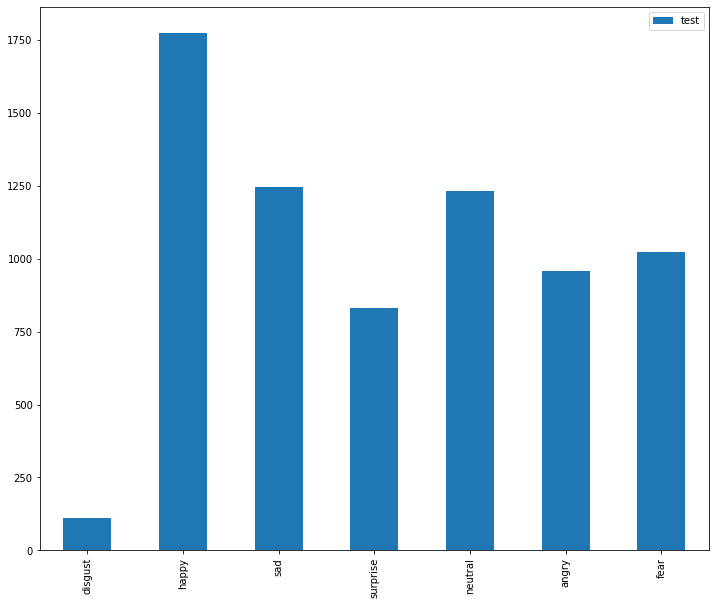

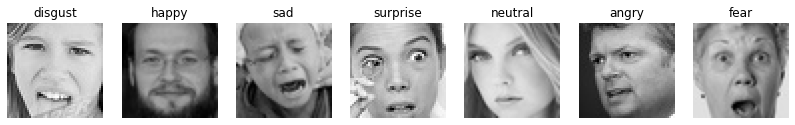

In [7]:
test_count.transpose().plot(kind='bar',figsize=(12, 10))

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Data Preprocessing



In [8]:
shutil.rmtree( './train/disgust')
shutil.rmtree( './test/disgust')


In [21]:
# train dataset
images = []
labels = []
for subset in os.listdir(train_dir):
  image_list = os.listdir(os.path.join(train_dir,subset))  # all the names of images in the directory
  image_list = list(map(lambda x:os.path.join(subset,x),image_list))
  images.extend(image_list)
  labels.extend([subset]*len(image_list)) 

df = pd.DataFrame({"Images":images,"Labels":labels})      
df = df.sample(frac=1).reset_index(drop=True) # this will shuffle the data
samplesize = int(int(df.size)/14)  # sample size used for modelling 
print(samplesize)
df_train = df.head(samplesize)  

4039


In [10]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [15]:
train_generator = datagen.flow_from_dataframe(
    directory = train_dir, 
    dataframe=df_train,
    x_col="Images",
    y_col="Labels",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    target_size=(48,48), 
    class_mode="categorical", 
    color_mode="grayscale"
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col="Images",
    y_col="Labels",
    subset="validation",
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48)
)

Found 3030 validated image filenames belonging to 6 classes.
Found 1009 validated image filenames belonging to 6 classes.


In [16]:
# test dataset
images = []
labels = []
for subset in os.listdir(test_dir):
  image_list = os.listdir(os.path.join(test_dir,subset))  # all the names of images in the directory
  image_list = list(map(lambda x:os.path.join(subset,x),image_list))
  images.extend(image_list)
  labels.extend([subset]*len(image_list)) 

df = pd.DataFrame({"Images":images,"Labels":labels})      
df = df.sample(frac=1).reset_index(drop=True) # To shuffle the data 
samplesize = int(int(df.size)/14)  # sample size used for modelling
print(samplesize)
df_test = df.head(samplesize) 

1009


In [17]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    directory = test_dir, 
    target_size=(48,48), 
    #class_mode="categorical", 
    class_mode=None,
    shuffle=False,
    color_mode="grayscale",
    dataframe = df_test,
    x_col="Images",
    y_col="Labels",
    batch_size=32,
    seed=42,
)

Found 1009 validated image filenames.


In [18]:
model= tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))


model.compile(
    optimizer = Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [19]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
firstModel = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

<ipython-input-19-ab8a583d4c63>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  firstModel = model.fit_generator(generator=train_generator,


Epoch 1/10
94/94 [==============================] - 101s 1s/step - loss: 2.2691 - accuracy: 0.2215 - val_loss: 5.0816 - val_accuracy: 0.1875
Epoch 2/10
94/94 [==============================] - 96s 1s/step - loss: 1.9098 - accuracy: 0.2982 - val_loss: 7.4967 - val_accuracy: 0.1875
Epoch 3/10
94/94 [==============================] - 98s 1s/step - loss: 1.7247 - accuracy: 0.3659 - val_loss: 7.2841 - val_accuracy: 0.1885
Epoch 4/10
94/94 [==============================] - 101s 1s/step - loss: 1.6494 - accuracy: 0.3879 - val_loss: 4.5029 - val_accuracy: 0.1028
Epoch 5/10
94/94 [==============================] - 99s 1s/step - loss: 1.4847 - accuracy: 0.4443 - val_loss: 4.5781 - val_accuracy: 0.1603
Epoch 6/10
94/94 [==============================] - 96s 1s/step - loss: 1.3620 - accuracy: 0.4940 - val_loss: 1.8595 - val_accuracy: 0.2560
Epoch 7/10
94/94 [==============================] - 98s 1s/step - loss: 1.1905 - accuracy: 0.5537 - val_loss: 1.7374 - val_accuracy: 0.3236
Epoch 8/10
94/94 [

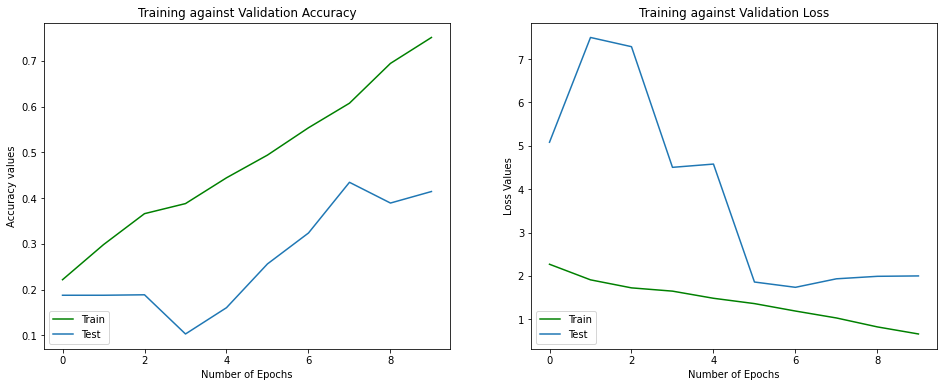

In [22]:
figure, axis = plt.subplots(1,2)
figure.set_size_inches(16,6)

train_ACC = firstModel.history['accuracy']
train_loss = firstModel.history['loss']

axis[0].plot(firstModel.history['accuracy'], color = "green")
axis[0].plot(firstModel.history['val_accuracy'])
axis[0].set_xlabel('Number of Epochs')
axis[0].set_ylabel('Accuracy values')
axis[0].set_title('Training against Validation Accuracy')
axis[0].legend(['Train', 'Test'], loc = 'lower left')

axis[1].plot(firstModel.history['loss'], color = "green")
axis[1].plot(firstModel.history['val_loss'])
axis[1].set_title('Training against Validation Loss')
axis[1].set_xlabel('Number of Epochs')
axis[1].set_ylabel('Loss Values')
axis[1].set_title('Training against Validation Loss')
axis[1].legend(['Train', 'Test'], loc ='lower left')

plt.show()

In [23]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_TEST)

<ipython-input-23-95b67568bf3e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(generator=valid_generator,


[1.9857758283615112, 0.41633063554763794]

In [28]:
test_generator.reset()
pred=model.predict(test_generator, steps=STEP_SIZE_TEST)

31/31 [==============================] - 10s 310ms/step


In [29]:
predicted_class_indices=np.argmax(pred,axis=1)

In [30]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


In [32]:
train_loss, train_ACC = model.evaluate(train_generator)
test_loss, test_ACC   = model.evaluate(valid_generator)
print("The train accuracy = {:.3f} , test accuracy = {:.3f}".format(train_ACC*100, test_ACC*100))

32/32 [==============================] - 8s 238ms/step - loss: 1.9989 - accuracy: 0.4153
The train accuracy = 83.828 , test accuracy = 41.526


##### Applying the model on a random image to test it.

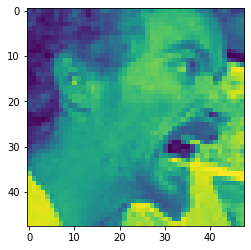

In [40]:
img = image.load_img("./test/angry/PrivateTest_10304478.jpg", target_size = (48,48), color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)

In [41]:
label_dict = {0:'Angry',1:'Fear',2:'Happy',3:'Neutral',4:'Sad',5:'Surprise'}


In [42]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 37ms/step
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [43]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Surprise
